# Coles stocks price generating X and y. 

## Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from col_eda import close_d_org, close_d, close_w, close_m, eda_df, model_training, cross_val

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [12, 8]

## Generate X and y

In [9]:
def generate_X_y(df, window_size, prediction_day):
    X = []
    y = []
    for i in range(len(df) - window_size - prediction_day + 1):
        X.append(df[i : i + window_size].values)
        y.append(df[i + window_size + prediction_day - 1])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [10]:
X, y = generate_X_y(close_d_org['Close'], 40, 1)

## Splitting the data

In [11]:
def spliting_data(X, y, train_ratio, train_val_ratio):
    train_cut = int(X.shape[0]*train_ratio)
    val_cut = int(X.shape[0]*train_val_ratio)
    X_train, X_val, X_test = X[:train_cut], X[train_cut:val_cut], X[val_cut:]
    y_train, y_val, y_test = y[:train_cut], y[train_cut:val_cut], y[val_cut:]
    return X_train, X_val, X_test, y_train, y_val, y_test

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = spliting_data(X, y, 0.7, 0.85)

## fit and predict

In [13]:
from sklearn.linear_model import LinearRegression
def fit_predict(models, X_train, X_val, y_train):
    model = models
    model.fit(X_train, y_train)
    predict_train = model.predict(X_train)
    predict_val = model.predict(X_val)
    return model, predict_train, predict_val

In [14]:
model, predict_train, predict_val = fit_predict(LinearRegression(), X_train, X_val, y_train)

## Evaluate

In [15]:
from sklearn.metrics import mean_squared_error as MSE, r2_score
def evaluate(y, predict):
    error = (MSE(y, predict))**(1/2)
    score = r2_score(y, predict)
    return error, score

In [16]:
error_val, score_val = evaluate(y_val, predict_val)

In [17]:
error_train, score_train = evaluate(y_train, predict_train)

## Plot actual vs predicted

In [18]:
def plot_actual_vs_predicted(actual, predicted, title='Actual vs. Predicted'):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

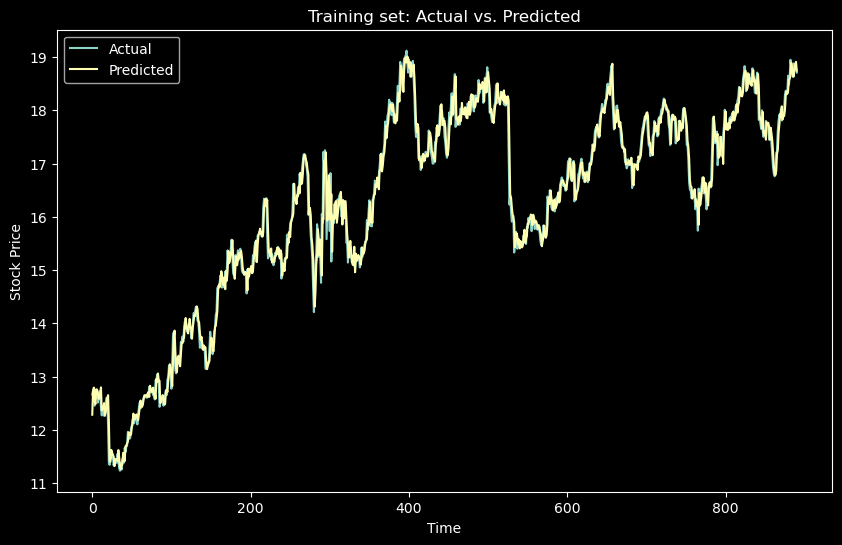

In [19]:
plot_actual_vs_predicted(y_train, predict_train, title='Training set: Actual vs. Predicted')

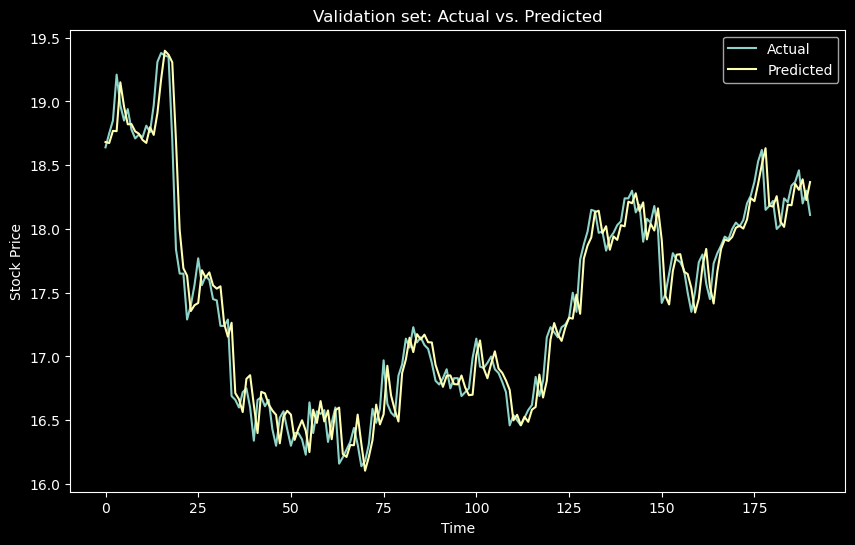

In [20]:
plot_actual_vs_predicted(y_val, predict_val, title='Validation set: Actual vs. Predicted')

## Tunning and cross val

In [23]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming X and y are your features and target variable, respectively

# Define a pipeline that includes preprocessing and the model
# StandardScaler is used here as an example of preprocessing
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])
    
    # Define the parameter grid to search
param_grid = {
    'model__alpha': np.logspace(-4, 4, 100)  # Example: Ridge regularization parameter
}
    
    # Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

def cross_val(pipeline, param_grid, tscv, X_train, y_train):    
    # Set up the GridSearchCV to search the parameters
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
    
    # Fit the GridSearchCV to the data
    grid_search.fit(X_train, y_train)
    
    # Best parameters and score
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", np.sqrt(-grid_search.best_score_))  # Assuming we're interested in RMSE


In [24]:
cross_val(pipeline, param_grid, tscv, X_train, y_train)

Best parameters: {'model__alpha': 1.3219411484660315}
Best score: 0.25969586345244017


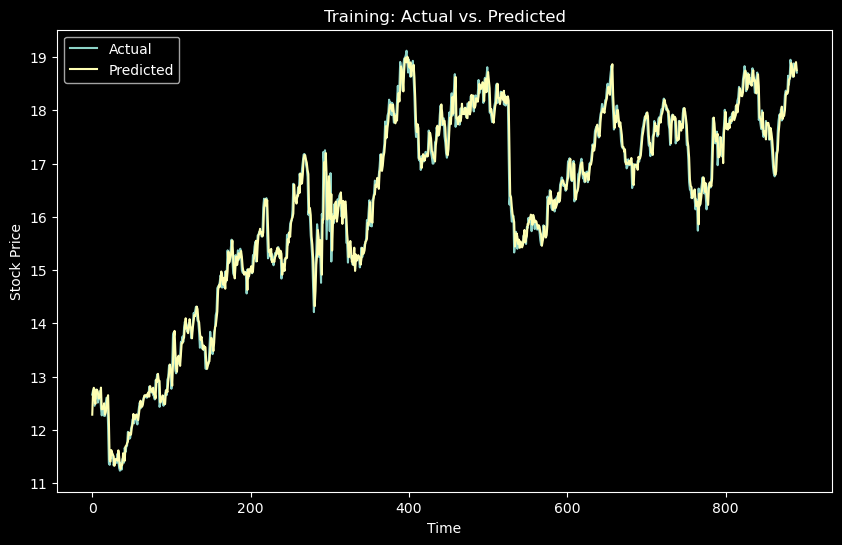

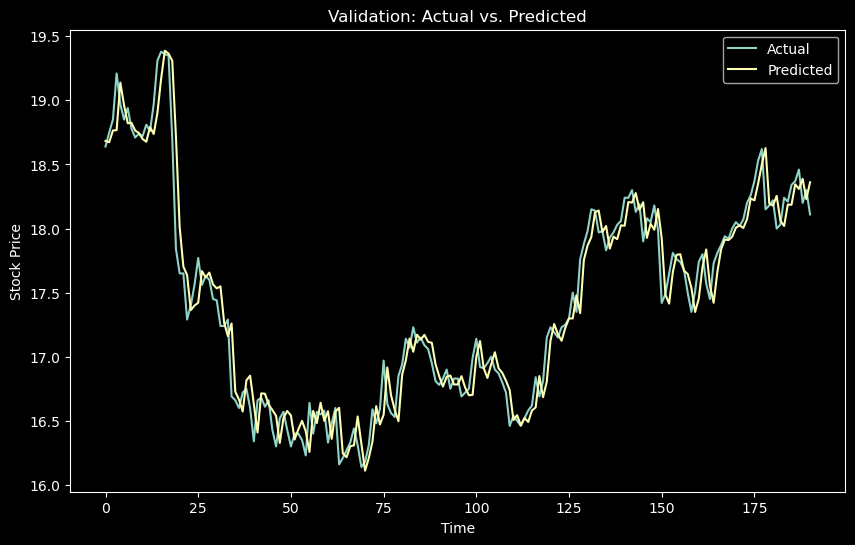

Training - RMSE: 0.2246992864063996, R2: 0.9865594042661404
Validation - RMSE: 0.1895323990771286, R2: 0.9460912208506914


In [22]:
model, X_train, y_train = model_training(close_d_org['Close'], 40, 1, 0.7, 0.85, Ridge(alpha=1.32))